In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("gold_price_data.csv")
# LET IMPORT OUR DATA DOE GOLD PREDICTION.

In [3]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


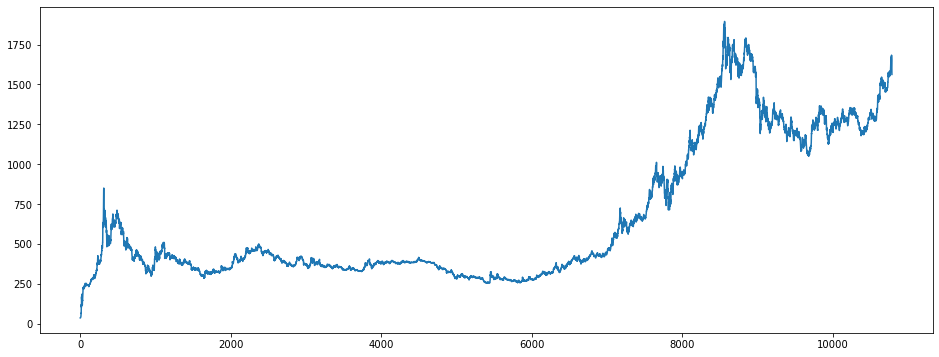

In [4]:
plt.figure(figsize=(16,6))
plt.plot(df["Value"])
plt.show()

In [5]:
result = seasonal_decompose(x=df["Value"], model ="multiplicative", period=4) 

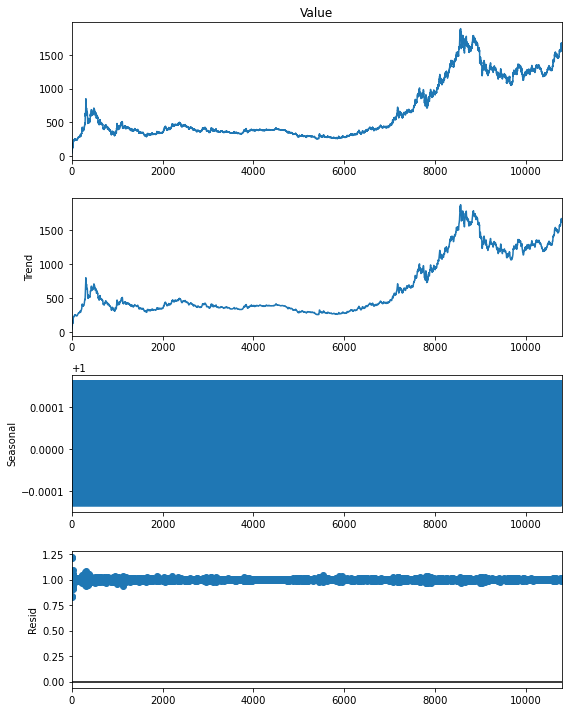

In [6]:
plt.rcParams.update({'figure.figsize': (8,10)})
result.plot()
plt.show()

There is Trend and Possible Sesonality

In [7]:
difference = df["Value"] - df["Value"].shift(4)

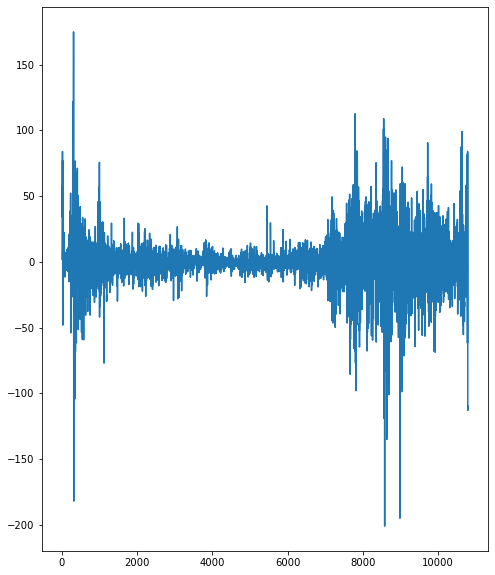

In [8]:
plt.plot(difference.dropna())

In [10]:
seasonal_difference = df["Value"] - df["Value"].shift(12)

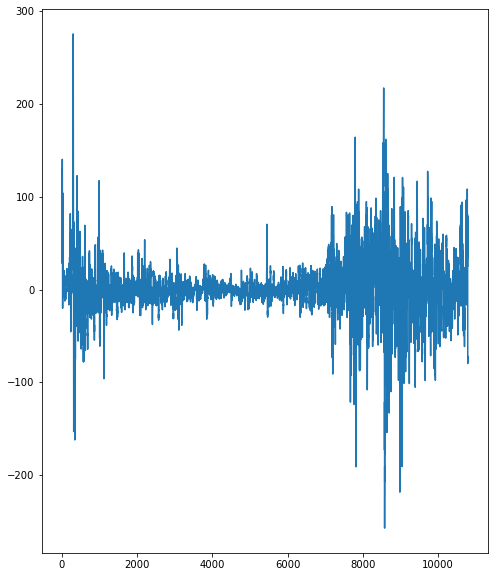

In [11]:
plt.plot(seasonal_difference.dropna())

In [12]:
double_difference = seasonal_difference - seasonal_difference.shift(1)

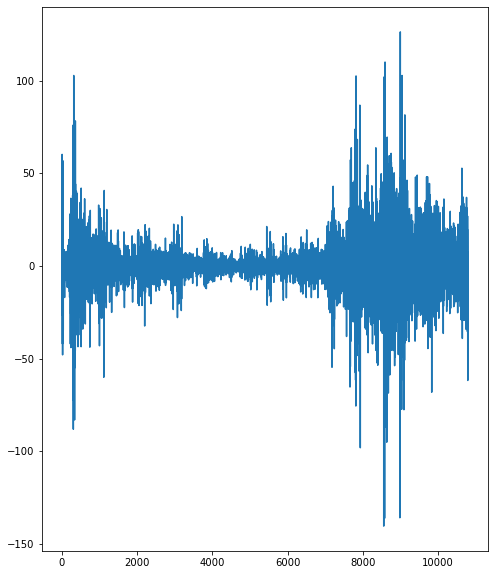

In [13]:
plt.plot(double_difference.dropna())

We have done second order difference hence d = 2  

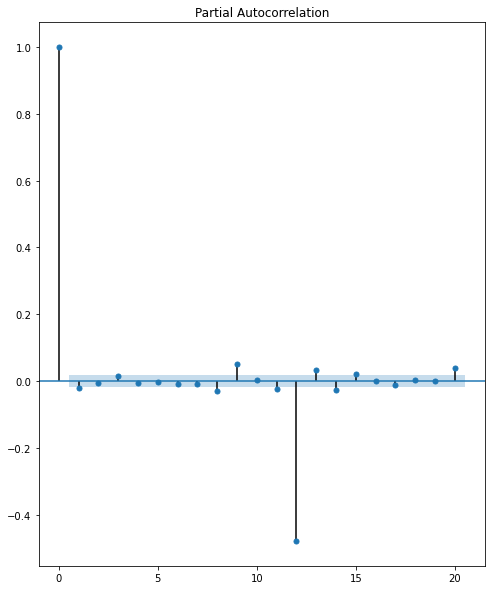

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(double_difference.dropna(), lags=20)
plt.show()

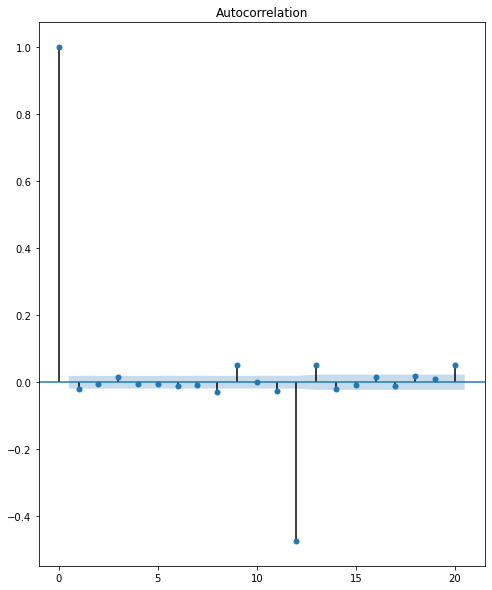

In [15]:
plot_acf(double_difference.dropna(), lags=20)
plt.show()

Value of p = 1, d = 2, q = 1

In [19]:
df["Value"].shape

(10787,)

Now lets move to use ARIMA model.

ARIMA is an acronym for “autoregressive integrated moving average.” It's a model used in statistics and econometrics to measure events that happen over a period of time. 
The model is used to understand past data or predict future data in a series.

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [44]:
model=ARIMA(df["Value"],order=(1,2,1))
model=model.fit()

In [46]:
df["forecast"] = model.predict(start=10000, end=11000)

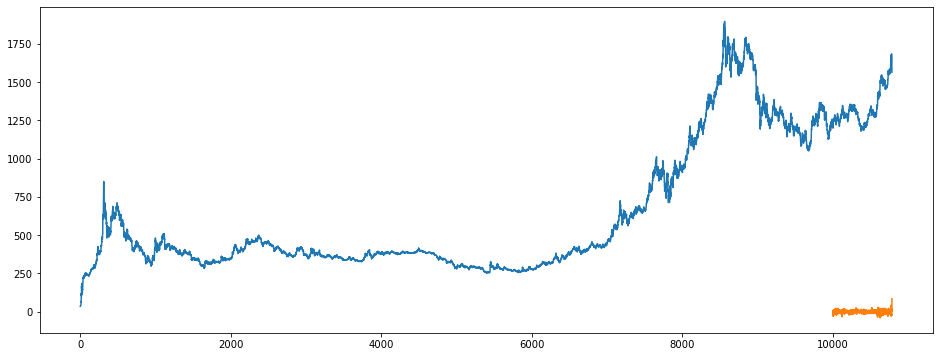

In [49]:
plt.figure(figsize=(16,6))
plt.plot(df[["Value","forecast"]])
plt.show()

The prediction is not what we expect, this might be because of residuals or trend or sesonality. Lets try SARIMAX

We are using SARIMAX since there is sesonality present there.

In [52]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [53]:
model = sm.tsa.statespace.SARIMAX(df['Value'],order=(1, 2, 1),seasonal_order=(1,2,1,4), trend="t")
model = model.fit()

In [54]:
df['forecast2']=model.predict(start=10000,end=11000)

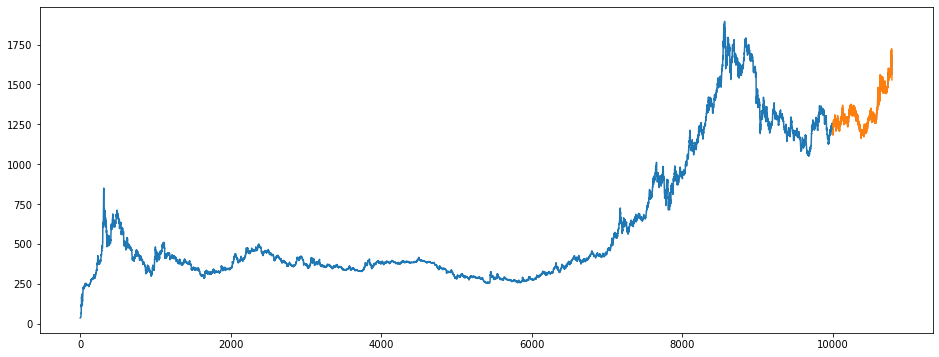

In [56]:
plt.figure(figsize=(16,6))
plt.plot(df[["Value","forecast2"]])
plt.show()

Lets MOve to using Simple ANN

In [22]:
df = pd.read_csv("gold_price_data.csv")
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [23]:
df.shape

(10787, 2)

In [24]:
train =df["Value"][:7550]
test = df["Value"][7550:]

In [25]:
train.shape

(7550,)

In [26]:
test.shape

(3237,)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, LSTM

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np

In [28]:

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(np.array(train).reshape(-1,1))
test_scaled = scaler.transform(np.array(test).reshape(-1,1))

In [29]:
#Array values converted to matrix data set
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        sample = dataset[i:(i+time_step), 0]    
        X.append(sample)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

Converting the data in order to make it feasible for Neural Network

In [30]:
time_step = 50
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

In [31]:
# reshape into (samples, time steps, features) 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test  = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
model = Sequential()
model.add(SimpleRNN(32, return_sequences=True, input_shape=(time_step,1)))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.fit(X_train,y_train, epochs=20, batch_size=32)

Epoch 1/20
235/235 [==============================] - 5s 14ms/step - loss: 0.0066
Epoch 2/20
235/235 [==============================] - 3s 13ms/step - loss: 1.3104e-04
Epoch 3/20
235/235 [==============================] - 3s 14ms/step - loss: 1.0290e-04
Epoch 4/20
235/235 [==============================] - 3s 14ms/step - loss: 8.8516e-05
Epoch 5/20
235/235 [==============================] - 3s 14ms/step - loss: 1.2146e-04
Epoch 6/20
235/235 [==============================] - 3s 14ms/step - loss: 1.5285e-04
Epoch 7/20
235/235 [==============================] - 3s 14ms/step - loss: 1.9823e-04
Epoch 8/20
235/235 [==============================] - 3s 14ms/step - loss: 8.8392e-05
Epoch 9/20
235/235 [==============================] - 3s 14ms/step - loss: 8.5812e-05
Epoch 10/20
235/235 [==============================] - 3s 14ms/step - loss: 9.6429e-05
Epoch 11/20
235/235 [==============================] - 3s 14ms/step - loss: 1.1541e-04
Epoch 12/20
235/235 [==============================] - 3

In [34]:
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred)

0.0722704488194497

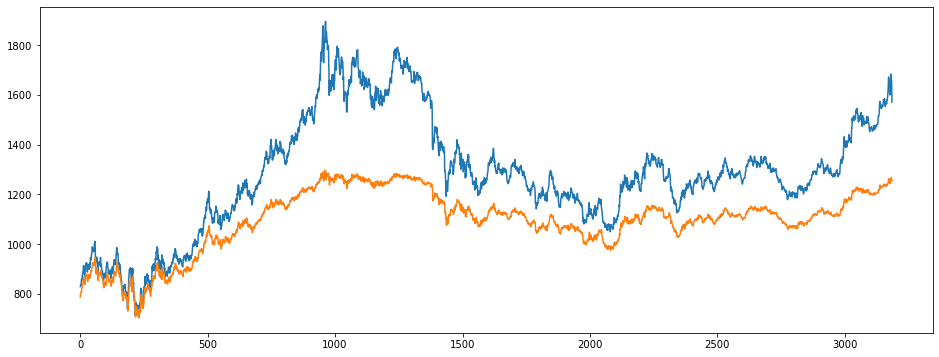

In [35]:
plt.figure(figsize=(16,6))
plt.plot(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))
plt.plot(scaler.inverse_transform(y_pred))
plt.show()

Now we use LSTM Model to predict.

The LSTM model is a type of RNN model that will learn a function that maps a sequence of past observations as input to an further outputs.


In [36]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
model.fit(X_train,y_train, epochs=50, batch_size=32)

Epoch 1/50
235/235 [==============================] - 16s 45ms/step - loss: 0.0202 1s - loss: 0.0 - ETA: 0s - l
Epoch 2/50
235/235 [==============================] - 10s 41ms/step - loss: 4.2216e-04
Epoch 3/50
235/235 [==============================] - 10s 41ms/step - loss: 4.3771e-04
Epoch 4/50
235/235 [==============================] - 10s 41ms/step - loss: 3.2887e-04
Epoch 5/50
235/235 [==============================] - 9s 40ms/step - loss: 3.0652e-04
Epoch 6/50
235/235 [==============================] - 9s 40ms/step - loss: 2.5349e-04
Epoch 7/50
235/235 [==============================] - 10s 41ms/step - loss: 2.2828e-04
Epoch 8/50
235/235 [==============================] - 9s 40ms/step - loss: 2.5157e-04
Epoch 9/50
235/235 [==============================] - 9s 40ms/step - loss: 1.7881e-04
Epoch 10/50
235/235 [==============================] - 9s 40ms/step - loss: 1.7458e-04
Epoch 11/50
235/235 [==============================] - 9s 40ms/step - loss: 2.1181e-04
Epoch 12/50
235/235 [=

In [38]:
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred)

0.05043307465437072

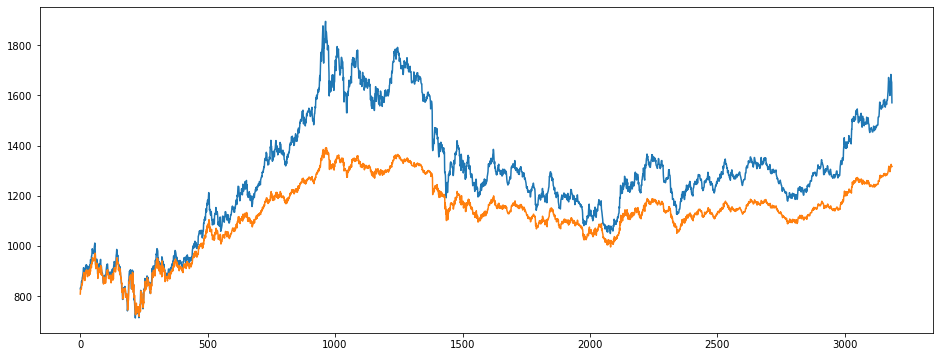

In [39]:
plt.figure(figsize=(16,6))
plt.plot(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))
plt.plot(scaler.inverse_transform(y_pred))
plt.show()

In [40]:
days = 50
last_input = X_test[-1]
last_output = y_pred[-1]
y_forecast = []

for i in range(1,days+1):
    last_input = np.append(last_input[1:], last_output)
    last_output = model.predict(last_input.reshape(1,50,1))
    y_forecast.append(last_output[0][0])

In [41]:
all_predictions = np.append(y_pred,y_forecast)

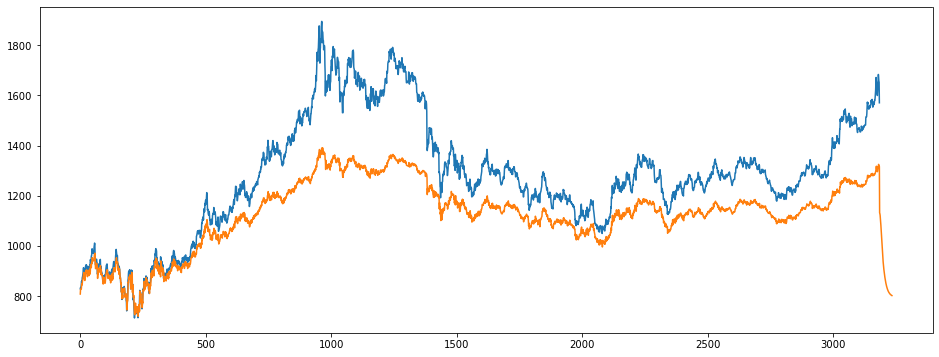

In [42]:
plt.figure(figsize=(16,6))
plt.plot(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))
plt.plot(scaler.inverse_transform(all_predictions.reshape(-1,1)))
plt.show()

The prediction obtained here is dropping off this shows the initial data as a whole needs some proper preproccessing, also it might still have sesonality and trend at a local scale since the data is very vast.